# Topic Detection

This tutorial explains 2 popular algorithms for topic detection and provides a practical example of using the sklearn's implementation of these algorithms.

This tutorial provides a high level knowledge of topic modelling and provides resources which can be referenced to learn further.


## What is Topic Detection/Modelling?

As more data science becoming more popular, there has been efforts to collect data in a clean and structured format but still there is a large amount of data which is prseent in unstructured text format as it is easier for humans to interpret. This unstructured text data is not just about numbers and features but also about emotions, facts, explainations etc. Topic detection is an effort to automatically detect what the text is all about.

## Why Topic Modelling

With knowledge of what the text is about, it would be easier to organize different text based on their topics. You can consider topic modelling as being similar to clustering text documents based on what the documents are all about.

An example of potential use of topic modelling could be recommendation of text documents to the user based on the text he has been reading in the past. These text documents could be news articles, novels, academic books. If a user has been reading a lot of articles about gender equality, it makes sense to recommend more articles on the same topic.

For this tutorial, We would use topic modelling to analyse what are the topics/issues that are popular in TED talks.

## Quick look at the topping modelling algorithms used in this tutorial?

#### LDA (Latent Dirichlet allocation)
wikipedia: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

For LDA, a topic is a probability distribution of different words that would occur in the document on a particular topic. Each document is assumed to be consisting of multiple topics.

For example, Topic "food" could have probability distributions for following words:
- Mango
- Apple
- Banana

and topic "health" could have probability distributions for following words:
- Excercise
- Lean
- Protein
- Sleep

Overall a document could then be assumed to consist of food (let's say 4/5th part of the document) and health (let's say 1/5th part of the document).

LDA tries to figure out what topics could have created the collection of documents being used as training data.

Good explaination about how LDA works could be found here: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

If you want to cover the topic in detail then this paper might be of great help: http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

#### NMF (Non-negative matrix factorization)
Sometimes also called NNMF

wikipedia: https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

Unlike LDA, NMF models are used for several different use cases and not just topic modelling. NMF is known to work well with high dimensional data and it is able to extract meaningful features from a set of large features provided. NMF inherently has a clustering property that makes it useful for topic modelling.

In depth details about NMF model could be found at: https://arxiv.org/abs/1401.5226


## Dataset

I am using a dataset which contains transcript of all recordings of TED Talks available on the officil TED talks website until September 21st, 2017. This dataset contains more information about each TED talk but I am only using the transcripts of these talks.

The dataset and more information about the dataset can be found at the url:
https://www.kaggle.com/rounakbanik/ted-talks

## Flow of tutorial

This tutorial is intended to help you understand steps in topic modelling starting with a basic dirty topic modelling implementation and then trying to improve incrementally from the first version.


## Let's Begin

In [1]:
import pandas as pd
import re
import nltk
import sklearn
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import collections
import operator
from scipy.misc import imread
import random
from wordcloud import WordCloud

random.seed(102832)
stop_words = nltk.corpus.stopwords.words('english')

### Reading the dataset

Let's read the data and have a quick look at what the data looks like

In [2]:
data_file = 'ted-talks/transcripts.csv'
transcript_data = pd.read_csv(data_file)
transcript_text = transcript_data.transcript
transcript_text.head()

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript, dtype: object

### Fitting an LDA and NMF Model

We will try to fit LDA (Latent Dirichlet allocation) and NMF (Non-negative matrix factorization) models for topic detection. Let us try see which of the two works better for the dataset being used.

Please note: This is not a comparison between LDA and NMF. We are trying to fit both the models (sklearn's implementation) without tuning and see which works better for out dataset using the default parameters. It might me possible to tweak these models to perform better or worse.

LDA models needs just the term frequency (tf) (word count in each document), while the NMF model needs trem frequency-inverse document frequency (tfidf). This is the reason, we have created 2 different vectorizers, one for LDA and one for NMF. It is possible to use tfidf for LDA model as well but I used tf, just to make it clear that we do not need tfidf for LDA.

NOTE: We are performing some preprocessing tasks directly through the vectorizer. We are removing stop words, rare words and frequent words using the sklearn's vectorizers. It is important to remove
- Stop words: as they do not contain any information about the topic
- Rare words: as very few documents have these words and thus it won't help in clustering documents together.
- Frequent words: as they are present in a large number of documents and would try to cluster many documents together.

In [3]:
# Fitting an LDA model.

# default English stop words from sklearn are being used. You can provide a set of custom stop words here.
# min_df is the minimum percentage of documents the word should be present in to not be considered a rare word.
# max_df is the maximum percentage of documents the word can be present in to not be considered a frequent word.
tf_vectorize = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english', min_df=0.05, max_df=0.4)
tf_documents = tf_vectorize.fit_transform(transcript_text)
# n_components is the number of topics.
# learning_method could be batch or online.
# An online learner can improve slowly as new data is passed to the model.
# While a batch algorithm assumes that training is done in one go and then the model is used without any learning later on.
lda = LatentDirichletAllocation(n_components = 10, learning_method= 'online')
lda.fit(tf_documents)

# Fitting a NMF model.
# default English stop words from sklearn are being used. You can provide a set of custom stop words here.
# min_df is the minimum percentage of documents the word should be present in to not be considered a rare word.
# max_df is the maximum percentage of documents the word can be present in to not be considered a frequent word.
tfidf_vectorize = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = 'english', min_df=0.05, max_df=0.4)
tfidf_documents = tfidf_vectorize.fit_transform(transcript_text)
# n_components is the number of topics.
nmf_model = NMF(n_components=10, init='random', random_state=0)
nmf_model.fit(tfidf_documents)
# So that information about the model object is not printed.
pass

### Analyzing the fitted model

Let us now look at the different words that are conatined in different topics. There might be overlaping words in different topics but that is fine.

There could be hundereds of words per topic but for the sake of understandability, I will just print the top 10 words in each topic.

In [4]:
# Inspired by: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    outp = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        outp['Topic '+str(topic_idx)] = features
    return outp
# Number of top words in each topic to be printed.
no_top_words = 10

#### LDA Model

In [5]:
display_topics(lda, tf_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,data,women,brain,music,money,countries,water,city,brain,children
1,technology,man,play,yeah,government,africa,earth,design,cancer,kids
2,computer,men,sound,ca,political,country,planet,building,cells,school
3,information,woman,sort,ok,public,food,energy,art,health,women
4,video,family,words,oh,companies,million,species,space,disease,students
5,machine,home,language,yes,dollars,dollars,light,project,body,social
6,internet,stories,mind,song,company,global,universe,create,patients,education
7,game,told,love,love,country,economic,animals,cities,blood,child
8,digital,young,okay,audience,global,india,ocean,built,cell,men
9,phone,love,moment,ted,states,business,space,build,medical,learn


#### NMF Model

In [6]:
display_topics(nmf_model, tfidf_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,city,cancer,brain,universe,women,countries,data,kids,water,music
1,cities,cells,brains,earth,men,africa,information,school,ocean,play
2,design,patients,cells,space,girls,country,computer,love,species,sound
3,building,disease,body,light,woman,government,technology,children,animals,song
4,buildings,cell,activity,stars,sex,money,machine,man,fish,ends
5,architecture,patient,behavior,planet,gender,global,internet,family,sea,video
6,space,health,arm,sun,female,dollars,video,god,food,piece
7,project,drug,mental,solar,violence,states,digital,mother,planet,hear
8,urban,blood,memory,energy,girl,china,web,told,ice,playing
9,built,body,mind,science,male,economic,computers,father,earth,sounds


### Cleaning and Lemmatizing

As we see, some topics have similar words mentioned twice in the same topic. Cell and Cells are considered different words but they are just different form of the same word. Let us clean the text a little and lemmatize words(Walk, Walks, Walking converts to the same word walk) in the text before trying to fit the models. This should improve the model. Let us try it and see.

In [7]:
# Reference : PDS assignment 3 - text classifcation
def lemmatize(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        str: normalized and lemmatized text
    """
    text = text.lower()
    text = text.replace("'s","")
    text = text.replace("'","")
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~]', ' ', text)
    digit_re = re.compile(r'\d')
    tokens = nltk.word_tokenize(text)
    words_re = re.compile(r'^[a-zA-Z]*$')
    out = []
    for token in tokens:
        try:
            if words_re.match(token) is not None:
                out.append(lemmatizer.lemmatize(token))
        except:
            pass
    return ' '.join(out)

processed_text = transcript_text.apply(lemmatize)

### Topic modelling with cleaned and lemmatized text

Let us try fitting the same models again on the processed text and see how the results change.

In [8]:
tf_documents = tf_vectorize.fit_transform(processed_text)
lda = LatentDirichletAllocation(n_components = 10, learning_method= 'online').fit(tf_documents)

tfidf_documents = tfidf_vectorize.fit_transform(processed_text)
nmf_model = NMF(n_components=10, init='random', random_state=0).fit(tfidf_documents)

In [9]:
display_topics(lda, tf_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,car,science,child,data,brain,city,woman,government,kid,music
1,food,universe,family,technology,cell,building,men,social,school,robot
2,energy,earth,love,computer,cancer,design,girl,money,game,light
3,water,theory,mother,information,patient,water,black,society,book,sound
4,dollar,space,man,machine,disease,space,young,global,student,earth
5,product,planet,friend,dna,body,project,community,africa,guy,video
6,plant,physic,told,digital,health,ocean,man,company,love,planet
7,cost,rule,moment,phone,drug,art,sex,political,play,play
8,oil,nature,id,network,study,tree,boy,business,teacher,image
9,billion,scientist,god,tool,blood,area,violence,power,video,space


In [10]:
display_topics(nmf_model, tfidf_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,woman,water,city,cancer,brain,music,government,love,school,computer
1,men,planet,building,cell,cell,sound,company,book,kid,data
2,girl,earth,design,patient,body,play,dollar,guy,child,robot
3,sex,ocean,space,disease,animal,song,money,god,teacher,machine
4,gender,animal,car,drug,memory,instrument,africa,man,student,technology
5,female,specie,community,health,behavior,video,business,friend,education,information
6,violence,sea,architecture,doctor,mind,hear,global,id,family,design
7,mother,plant,street,body,gene,piece,economy,moment,parent,video
8,boy,fish,neighborhood,dna,pattern,playing,market,art,girl,device
9,male,universe,urban,blood,signal,noise,social,oh,learning,digital


In general, topics are more coherent (contains similar words after cleaning and lemmatizing), but some topics created by LDA still doesn't make much sense(to a human like you and me, even though it may make sense for the machine) and they are difficult to interpret. For example, let's look at Topic 2, 3 and 5. Personally, I feel that the NMF model is more interpretable and will be using the creating NMF model. This is because interpretablity and clarity of what each topic means is an important issue when modelling topics.

This intuition is not only deciding factor to be used when modelling topics. Metrics like perplexity and cosine similarity could be used to select and parameters and models for a particular problem.

### Labelling different topics (NMF Model)

Let us label different topics so that it is easier to follow what the talk is about. It becomes confusing when we have to go back to the words present in the topic to make sense of what the topic is about. Naming these topics makes it more interpretable and understandable to a human and, we would not need to go back to the word list each time we talk about a particular topic.

- Topic 0 : Women empowerment/Gender
- Topic 1 : Nature/Universe
- Topic 2 : Design/Architecture
- Topic 3 : Health
- Topic 4 : Brain/Intelligence
- Topic 5 : Music/Entertainment
- Topic 6 : Global economy
- Topic 7 : Philosophy
- Topic 8 : Education/Child development
- Topic 9 : Computers/Technology


In [11]:
topic_labels = ['Women empowerment/Gender', 'Nature/Universe', 'Design/Architecture', 'Health', 'Brain/Intelligence', 
                'Music/Entertainment', 'Global economy', 'Philosophy/Art', 'Education/Child development',
                'Computers/Technology']

## Analysing the topics of TED talks

Let us now, use our model to find topics for all the TED talks in the dataset and see what are the most popular topics for TED talks by looking at the count of talks on each topic.

#### Putting each document in the most likely topic

In [12]:
# Essentially, a prediction method to predict the most likely topic for this document.
def find_most_likely_topic(data, model, topic_labels):
    topic_out = []
    topic_probs = model.transform(data)
    for topic_prob in topic_probs:
        topic_out.append(topic_prob.argmax())
    labelled_topics = [topic_labels[x] for x in topic_out]
    return labelled_topics

topics = find_most_likely_topic(tfidf_documents, nmf_model, topic_labels)

#### Counting documents in each topic to see what topics are most popular

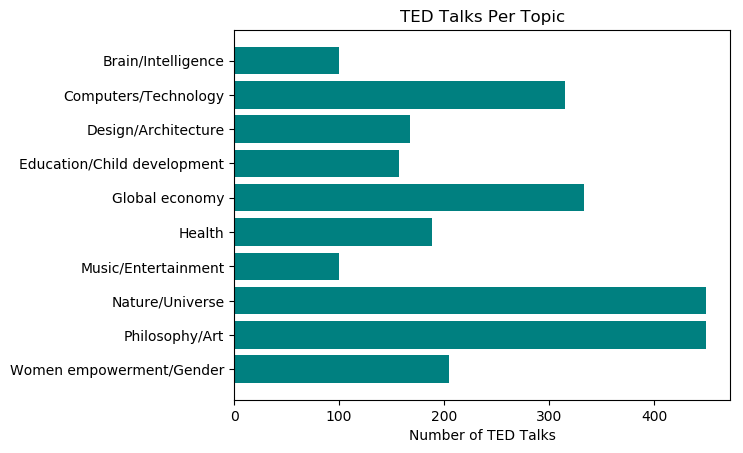

In [13]:
topics_count = collections.Counter(topics)

topic_names = list(topics_count.keys())
bar_length = list(topics_count.values())

# Reference: https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(topic_names, bar_length, align='center',
        color='teal', ecolor='black')
ax.invert_yaxis() 
ax.set_xlabel('Number of TED Talks')
ax.set_title('TED Talks Per Topic')
plt.show()

As seen by the plot above, most of the TED talks were about Philosphy and Nature/Universe, while Global economy was the next most popular topic.

## Testing models on a random talk

I scraped a transcript for a TED Talk not included in the dataset used to fit topic model. Let us see what this talk is all about by creating a word cloud and let us see if the topic model provides a topic consistent with the content of the talk.

### Word Cloud of the talk

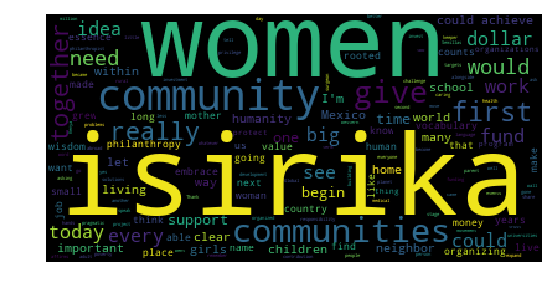

In [14]:
test_text = ''
with open('new_ted_talk.txt', 'r') as test_script:
    test_text = test_script.read()

# Refernce: https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = stop_words # set or space-separated string
                      ).generate(test_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Is this document put in the correct topic?
Let us try the model to check what is the most likely topic for this document based on our NMF model.

In [15]:
test_processed = [lemmatize(test_text)]
tfidf_test = tfidf_vectorize.transform(test_processed)

topic_number = nmf_model.transform(tfidf_test).argmax()
topic_labels[topic_number]

'Women empowerment/Gender'

The test data used was transcript of the TED talk named
"Musimbi Kanyoro: To solve the world's biggest problems, invest in women and girls"
and out NMF model correctly put it under topic 'Women empowerment/Gender'.

## Further Motivation

For the tutorial, we did not make use of n-grams which might provide even better topic modelling and is something that should be considered when doing topic modelling for a real life problem. 

### What is an N-gram

N-gram is a combination of N words that occur together in a particular order and ideally have different meaning from the words in it. For example: "Black Hole" has a different meaning from a hole that is black. Similarly "United States of America", "Latent Dirichlet allocation" etc


Here is an example of how that can be done using sklearn's NMF model. It can similarly be done for LDA model as well.

In [16]:
ngram_vectorize = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = 'english', min_df=0.05, max_df=0.4,
                                                                  ngram_range = (1,2))
ngram_documents = ngram_vectorize.fit_transform(processed_text)
ngram_nmf_model = NMF(n_components=10, init='random', random_state=0)
ngram_nmf_model.fit(ngram_documents)
display_topics(ngram_nmf_model, ngram_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,city,love,cancer,music,brain,computer,woman,government,water,school
1,building,guy,cell,sound,cell,data,men,company,planet,child
2,design,book,patient,play,body,robot,girl,dollar,earth,kid
3,space,god,disease,song,animal,machine,sex,money,ocean,teacher
4,car,man,drug,instrument,memory,technology,gender,africa,animal,student
5,community,friend,health,video,mind,information,female,business,specie,education
6,architecture,id,doctor,hear,behavior,design,violence,global,sea,family
7,street,moment,body,piece,gene,video,mother,economy,plant,parent
8,neighborhood,oh,dna,playing,pattern,device,boy,market,universe,girl
9,urban,art,blood,noise,signal,digital,male,social,fish,learning


There are no n-grams in the top 10 words for any of the topics. This does not mean that the n-grams are not being used in the model. Let us try to print top 10 n-grams in the model to make sure that there are n-grams being considered in the model.

In [17]:
# Inspired by: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_n_gram_topics(model, feature_names, no_top_words):
    outp = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i]
                        for i in topic.argsort() if ' ' in feature_names[i]]
        outp['Topic '+str(topic_idx)] = features[:no_top_words]
    return outp

display_n_gram_topics(ngram_nmf_model, ngram_vectorize.get_feature_names(), no_top_words)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,dont want,billion dollar,people say,time wa,seven year,day day,sort thing,feel like,group people,way make
1,people dont,billion people,people really,laughter wa,said wa,place like,make sense,felt like,feel like,im just
2,dont understand,climate change,people people,laughter think,said know,didnt want,thing make,im trying,im saying,im really
3,dont think,real time,place like,let say,said im,did know,thing know,high school,health care,weve seen
4,people say,health care,dont just,think thing,said dont,said dont,thing just,did know,high school,going talk
5,doe mean,country world,right laughter,thought wa,health care,said im,thing happened,thing wa,thousand people,laughter im
6,doesnt mean,weve seen,dont think,like people,high school,said wa,million dollar,think wa,think thing,laughter think
7,doesnt work,million year,real world,like know,going happen,say im,thing dont,thought wa,think people,let just
8,dont know,million dollar,doing thing,life wa,going make,climate change,theyre going,didnt want,thing people,let look
9,really need,place like,did know,laughter know,felt like,country world,theyre doing,thing know,doesnt work,like im


If you look at the ngrams included in the topic model, some of them makes real difference when considered as an ngram rather than considering the ngram as two or more seperate words.  For example: "real time" is a different word from "real" and "time". Similarly for . This makes the topic model more accurate as more features are now available to the model to select from.

## Selecting optimal number of topics

Another question that is not considered in the tutorial is how to select the optimal number of topics? Would it be better if we use 12 instead of 10 topics or should we use lesser? It depends on how many different types of topics are actually present in the corpora(text documents). How do we quantify what selection of number of topics is optimal?

These are important questions that should be thought about when using topic modelling. More information on how this can be done could be found at: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

This article provides a good way to select the optimal number of topics and also provides how topic modelling could be done using the Gensim package, which is growing in popularity these days.

## References
- https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
